In [15]:
import numpy as np
from os import listdir

In [174]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
from torch.nn import Module, Linear
from torch.nn import LeakyReLU, ReLU, Conv2d, ConvTranspose2d, Tanh
from torch.nn import BatchNorm2d, Dropout, Dropout2d, Flatten

from models.bayeslayers import BayesianLayer


class BaseVariational(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, debug=False):
        for layer in self.layers:
            x = layer(x)
            # if isinstance(layer, nn.Flatten):
            #     print(x.shape)
            if debug:
                print("layer {}".format(layer))
                print("shape {}".format(x.shape))
                print("")
        return x

    def predict(self, x, num_forward_passes=10):
        pred = self.forward(x)
        for i in range(num_forward_passes - 1):
            pred += self.forward(x)
        pred = pred / num_forward_passes

        return latent

    def kl_loss(self):
        '''
        Computes the KL divergence loss for all layers.
        '''
        kl = 0
        for i, layer in enumerate(self.layers):
            if isinstance(layer, BayesianLayer):
                kl_ = layer.kl_divergence()
                kl += kl_
        return kl

class CnnAE(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        latent_representation = self.encoder(x)
        reconstruction = self.decoder(latent_representation)
        return reconstruction

    def predict(self, x, num_forward_passes=10):

        latent_representation = self.encoder(x)
        reconstruction = self.decoder(latent_representation)

        for i in range(num_forward_passes - 1):
            curr_latent = self.encoder(x)
            latent_representation += curr_latent
            reconstruction += self.decoder(curr_latent)
        latent_representation = latent_representation / num_forward_passes
        reconstruction = reconstruction / num_forward_passes

        return latent_representation, reconstruction
    def params(self):
        return list(self.encoder.parameters()) + list(self.decoder.parameters())


    def kl_loss(self):
        '''
        Computes the KL divergence loss for all layers.
        '''
        kl = 0
        for i, layer in enumerate(self.encoder.layers):
            if isinstance(layer, BayesianLayer):
                kl_ = layer.kl_divergence()
                kl += kl_
        return kl

In [11]:
! ls

README.md               sample2.zip             test_models.py
Train                   small_ae_15_latents.txt zip_and_delete.py
models                  small_ae_25_latents.txt zipped_npy_2.zip
models_lab.ipynb        sok_example.py


In [12]:
! unzip zipped_npy_2.zip

Archive:  zipped_npy_2.zip
 extracting: states_gameplay_0.npy   
 extracting: states_scaled_gameplay_0.npy  
 extracting: actions_gameplay_0.npy  
 extracting: next_states_gameplay_0.npy  
 extracting: rewards_gameplay_0.npy  
 extracting: done_gameplay_0.npy     
 extracting: next_states_scaled_gameplay_0.npy  


In [20]:
files_here = listdir()
np_files = [x for x in files_here if x.endswith('.npy')]
actions = np.array([])
next_states_scaled = np.array([])
scaled = np.array([])

for idx, file_name in enumerate(np_files):
  with open(file_name, 'rb') as f:
    current_array = np.load(f) 
  print(file_name)
  if file_name.startswith('states_scaled'):
    if len(scaled) == 0:
      scaled = current_array
    else:
      scaled = np.concatenate([scaled, current_array])
  elif file_name.startswith('next_states_scaled'):
    if len(next_states_scaled) == 0:
      next_states_scaled = current_array
    else:
      next_states_scaled = np.concatenate([next_states_scaled, current_array])
  elif file_name.startswith('actions'):
    if len(actions) == 0:
      actions = current_array
    else:
      actions = np.concatenate([actions, current_array])
  

states_gameplay_0.npy
states_scaled_gameplay_0.npy
actions_gameplay_0.npy
next_states_gameplay_0.npy
rewards_gameplay_0.npy
done_gameplay_0.npy
next_states_scaled_gameplay_0.npy


In [21]:
train_scaled, eval_scaled, train_next_states, eval_next_states = train_test_split(
    scaled, next_states_scaled, test_size=0.15, random_state=42)

train_actions, eval_actions = train_test_split(actions, test_size=0.15, random_state=42)

In [24]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, action_next_state=(None, None), transform=None):
        self.data = data
        self.transform = transform
        self.action, self.next_state = action_next_state       

    def __getitem__(self, index):
        x = self.data[index]

        if self.transform:
            x = self.transform(x)

        items = x
        if self.action is not None:
            y = self.action[index]
            z = self.next_state[index]
            z = self.transform(z)
            items = (x, y, z)

        return items

    def __len__(self):
        return len(self.data)

means = torch.tensor([0.5, 0.5, 0.5], dtype=torch.float32)
stds = torch.tensor([0.5, 0.5, 0.5], dtype=torch.float32)
to_tensor = torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                                        mean=means,
                                                        std=stds)
                                             ])


scaled_states_actions_dataset = MyDataset(train_scaled, (train_actions, train_next_states), transform=to_tensor)
scaled_states_actions_loader = torch.utils.data.DataLoader(scaled_states_actions_dataset, batch_size=64,
                                                    shuffle=True)

eval_scaled_states_actions_dataset = MyDataset(eval_scaled, (eval_actions , eval_next_states), transform=to_tensor)
eval_scaled_states_actions_loader = torch.utils.data.DataLoader(eval_scaled_states_actions_dataset, batch_size=2,
                                                    shuffle=True)


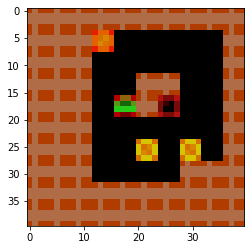

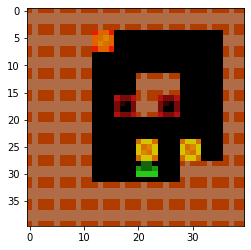

In [31]:
def show_img(img_tensor):
    img = img_tensor[0]
    denormed_img = denormalize(img)
    plt.imshow(denormed_img.detach().numpy().transpose(1, 2, 0))
    plt.show()

def denormalize(normed_img):

    return normed_img * stds[:, None, None] + means[:, None, None]

_, (state, action, next_state) = next(enumerate(scaled_states_actions_loader))
show_img(state)

_, (state, action, next_state) = next(enumerate(eval_scaled_states_actions_loader))
show_img(state)

In [103]:
class DeepEncoderSmall(BaseVariational):
    '''
    Takes in as input batches of images of size [batch_size, 40, 40, 3]
    '''
    def __init__(self, latent_size=9):
        super().__init__()
        self.latent_size = latent_size
        self.layers = torch.nn.ModuleList(self._init_layers())

    def _init_layers(self):
        layers = [
                Conv2d(in_channels=3, out_channels=32,
                      kernel_size=3, stride=2, padding=1),
                ReLU(),
                Conv2d(in_channels=32, out_channels=64,
                          kernel_size=3, stride=2, padding=1),
                ReLU(),
                Conv2d(in_channels=64, out_channels=128,
                          kernel_size=3, stride=2, padding=1),
                BatchNorm2d(128),
                ReLU(),
                Conv2d(in_channels=128, out_channels=256,
                          kernel_size=3, stride=2, padding=1),
                ReLU(),
                Conv2d(in_channels=256, out_channels=256,
                          kernel_size=3, stride=3, padding=4),
                ReLU(),
                Conv2d(in_channels=256, out_channels=512,
                          kernel_size=3, stride=1, padding=1),
                BatchNorm2d(512),
                ReLU(),
                Conv2d(in_channels=512, out_channels=512,
                          kernel_size=3, stride=3, padding=4),
                BatchNorm2d(512),
                ReLU(),
                Conv2d(in_channels=512, out_channels=1024,
                          kernel_size=3, stride=1, padding=1),
                BatchNorm2d(1024),
                ReLU(),
                Conv2d(in_channels=1024, out_channels=1024,
                          kernel_size=3, stride=3, padding=4),
                BatchNorm2d(1024),
                ReLU(),
                Dropout2d(p=0.25),
                Flatten(),
                Dropout(p=0.4),
                Linear(9216, int(9216 / 9)),
                ReLU(),
                Dropout(p=0.4),
                BayesianLayer(int(9216 / 9), self.latent_size)]
        return layers

In [104]:
encoder = EncoderSmall(9)
encoded = encoder(state, debug=True)
print(state.shape)

layer Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
shape torch.Size([2, 32, 20, 20])

layer ReLU()
shape torch.Size([2, 32, 20, 20])

layer Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
shape torch.Size([2, 64, 10, 10])

layer ReLU()
shape torch.Size([2, 64, 10, 10])

layer Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
shape torch.Size([2, 128, 5, 5])

layer BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
shape torch.Size([2, 128, 5, 5])

layer ReLU()
shape torch.Size([2, 128, 5, 5])

layer Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
shape torch.Size([2, 256, 3, 3])

layer ReLU()
shape torch.Size([2, 256, 3, 3])

layer Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
shape torch.Size([2, 512, 3, 3])

layer BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
shape torch.Size([2, 512, 3, 3])

layer ReLU()
shape torch.Size([2

In [107]:
class DeepDecoderSmall(BaseVariational):
    '''
    Use with SmallDecoder.
    will take a Dense vector and turn it into batches of size [batch_size, 40, 40, 3]
    '''
    def __init__(self, latent_size):
        super().__init__()
        self.latent_size = latent_size
        self.layers = torch.nn.ModuleList(self._init_layers())

    def _init_layers(self):
        self.start_decode = Linear(self.latent_size, int(9216 / 9))
        self.drop_linear_one = Dropout(p=0.4)
        self.start_decodeb = Linear(int(9216 / 9), 9216)
        self.drop_linear_two = Dropout(p=0.4)
        layers = [
                ConvTranspose2d(in_channels=1024, out_channels=1024,
                          kernel_size=3, stride=3, padding=3),
                BatchNorm2d(1024),
                Dropout2d(p=0.25),
                ReLU(),
                ConvTranspose2d(in_channels=1024, out_channels=1024,
                          kernel_size=3, stride=3, padding=3),
                BatchNorm2d(1024),
                Dropout2d(p=0.25),
                ReLU(),
                ConvTranspose2d(in_channels=1024, out_channels=512,
                          kernel_size=3, stride=2, padding=1, output_padding=1),
                BatchNorm2d(512),
                Dropout2d(p=0.25),
                ReLU(),
                ConvTranspose2d(in_channels=512, out_channels=512,
                          kernel_size=3, stride=3, padding=3),
                BatchNorm2d(512),
                Dropout2d(p=0.25),
                ReLU(),
                ConvTranspose2d(in_channels=512, out_channels=256,
                          kernel_size=3, stride=2, padding=1, output_padding=1),
                BatchNorm2d(256),
                ReLU(),
                ConvTranspose2d(in_channels=256, out_channels=256,
                          kernel_size=3, stride=3, padding=3),
                BatchNorm2d(256),
                ReLU(),
                ConvTranspose2d(in_channels=256, out_channels=128,
                          kernel_size=3, stride=2, padding=1),
                BatchNorm2d(128),
                ReLU(),
                ConvTranspose2d(in_channels=128, out_channels=128,
                          kernel_size=3, stride=3, padding=3),
                BatchNorm2d(128),
                ReLU(),
                ConvTranspose2d(in_channels=128, out_channels=64,
                      kernel_size=3, stride=2, padding=2),
                BatchNorm2d(64),
                ReLU(),
                ConvTranspose2d(in_channels=64, out_channels=32,
                          kernel_size=3, stride=1, padding=1),
                BatchNorm2d(32),
                ReLU(),
                ConvTranspose2d(in_channels=32, out_channels=16,
                                          kernel_size=3, stride=1, padding=1),
                ReLU(),
                BatchNorm2d(16),
                Conv2d(in_channels=16, out_channels=8,
                          kernel_size=4, stride=1, padding=1),
                ReLU(),   
                Conv2d(in_channels=8, out_channels=3,
                          kernel_size=3, stride=1, padding=0),
                Tanh()    
            ]
        return layers
    
    def forward(self, x, debug=False):
        x = self.start_decode(x)
        x = self.drop_linear_one(x)
        x = F.relu(x)
        x = self.start_decodeb(x)
        x = self.drop_linear_two(x)
        x = F.relu(x)
        x = x.reshape(-1, 1024, 3, 3)

        for idx, layer in enumerate(self.layers):
            x = layer(x)
            if debug:
                print("layer {}".format(layer))
                print("shape {}".format(x.shape))
                print("")
        return x

In [108]:
decoder = DecoderSmall(9)
decoded = decoder(encoded, debug=True)

layer ConvTranspose2d(1024, 1024, kernel_size=(3, 3), stride=(3, 3), padding=(3, 3))
shape torch.Size([2, 1024, 3, 3])

layer BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
shape torch.Size([2, 1024, 3, 3])

layer Dropout2d(p=0.25, inplace=False)
shape torch.Size([2, 1024, 3, 3])

layer ReLU()
shape torch.Size([2, 1024, 3, 3])

layer ConvTranspose2d(1024, 1024, kernel_size=(3, 3), stride=(3, 3), padding=(3, 3))
shape torch.Size([2, 1024, 3, 3])

layer BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
shape torch.Size([2, 1024, 3, 3])

layer Dropout2d(p=0.25, inplace=False)
shape torch.Size([2, 1024, 3, 3])

layer ReLU()
shape torch.Size([2, 1024, 3, 3])

layer ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
shape torch.Size([2, 512, 6, 6])

layer BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
shape torch.Size([2, 512, 6, 6])

layer Dr

In [99]:
state.shape

torch.Size([2, 3, 40, 40])

In [187]:
class SmallEncoder40(BaseVariational):
    '''
    Takes in as input batches of images of size [batch_size, 40, 40, 3]
    '''
    def __init__(self, latent_size, layers_dims, activation='relu'):
        super().__init__()
        self.latent_size = latent_size
        self.layers_dims = layers_dims
        self.activation = LeakyReLU if activation is not 'relu' else ReLU
        self.layers = torch.nn.ModuleList(self._init_layers())

    def _init_layers(self):
        layers = []
        for idx, dims in enumerate(self.layers_dims):
            if idx == 0:
                current_dims = 3
                next_dims = dims
            else:
                current_dims = self.layers_dims[idx - 1]
                next_dims = dims

            layers.extend(
                    [
                    Conv2d(in_channels=current_dims, out_channels=next_dims,
                           kernel_size=3, stride=2, padding=1),
                    BatchNorm2d(next_dims),
                    self.activation(),
                    ])

        flat_size = self.layers_dims[-1] * 5 * 5
        layers.extend([
                Flatten(),
                Dropout(p=0.25),
                Linear(flat_size, int(flat_size / 9)),
                ReLU(),
                #Dropout(p=0.4),
                BayesianLayer(int(flat_size / 9), self.latent_size)]
        )
        return layers

In [192]:
layers_dims = [32, 64, 128]
encoder = SmallEncoder40(9, layers_dims, 'relu')
encoded = encoder(state, debug=True)

layer Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
shape torch.Size([2, 32, 20, 20])

layer BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
shape torch.Size([2, 32, 20, 20])

layer ReLU()
shape torch.Size([2, 32, 20, 20])

layer Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
shape torch.Size([2, 64, 10, 10])

layer BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
shape torch.Size([2, 64, 10, 10])

layer ReLU()
shape torch.Size([2, 64, 10, 10])

layer Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
shape torch.Size([2, 128, 5, 5])

layer BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
shape torch.Size([2, 128, 5, 5])

layer ReLU()
shape torch.Size([2, 128, 5, 5])

layer Flatten()
shape torch.Size([2, 3200])

layer Dropout(p=0.25, inplace=False)
shape torch.Size([2, 3200])

layer Linear(in_features=3200, out_features=355, bias=True)
sha

In [196]:
class SmallDecoder40(BaseVariational):
    '''
    Use with SmallEncoder40.
    will take a Dense vector and turn it into batches of size [batch_size, 40, 40, 3]
    '''
    def __init__(self, latent_size, layers_dims, activation='relu'):
        super().__init__()
        self.latent_size = latent_size
        self.layers_dims = layers_dims
        self.activation = LeakyReLU if activation is not 'relu' else ReLU
        self.layers = torch.nn.ModuleList(self._init_layers())

    def _init_layers(self):
        flat_size = self.layers_dims[0] * 5 * 5
        self.start_decode = Linear(self.latent_size, int(flat_size / 9))
        self.drop_linear_one = Dropout(p=0.4)
        self.start_decodeb = Linear(int(flat_size / 9), flat_size)
        self.drop_linear_two = Dropout(p=0.4)

        stride = 3
        padding = 3
        output_padding = 0
        layers = []
        for idx, dims in enumerate(self.layers_dims):

            if idx == 2:
                current_dims = dims
                next_dims = 8
            else:
                current_dims = dims
                next_dims = self.layers_dims[idx + 1]

            if idx == 2:
                stride = 2
                padding = 1
                output_padding = 1

            layers.extend(
                [
                Dropout2d(p=0.1),
                ConvTranspose2d(in_channels=current_dims,
                                 out_channels=next_dims,
                                 kernel_size=3, stride=stride, padding=padding,
                                 output_padding=output_padding),
                BatchNorm2d(next_dims),
                self.activation()
                ]
              )

        layers.extend(
                [Conv2d(in_channels=8, out_channels=3,
                        kernel_size=3, stride=1, padding=0),
                 Tanh()]
                    )
        return layers
    
    def forward(self, x, debug=False):
        x = self.drop_linear_one(x)
        x = self.start_decode(x)
        x = F.relu(x)
        x = self.drop_linear_two(x)
        x = self.start_decodeb(x)
        x = F.relu(x)
        
        init_channels = self.layers_dims[0]
        x = x.reshape(-1, init_channels, 5, 5)

        for idx, layer in enumerate(self.layers):
            x = layer(x)
            if debug:
                print("layer {}".format(layer))
                print("shape {}".format(x.shape))
                print("")
        return x

In [197]:
decoder = SmallDecoder40(9, [128, 64, 32], 'leaky')
decoded = decoder(encoded, debug=True)

layer Dropout2d(p=0.1, inplace=False)
shape torch.Size([2, 128, 5, 5])

layer ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(3, 3), padding=(3, 3))
shape torch.Size([2, 64, 9, 9])

layer BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
shape torch.Size([2, 64, 9, 9])

layer LeakyReLU(negative_slope=0.01)
shape torch.Size([2, 64, 9, 9])

layer Dropout2d(p=0.1, inplace=False)
shape torch.Size([2, 64, 9, 9])

layer ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(3, 3), padding=(3, 3))
shape torch.Size([2, 32, 21, 21])

layer BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
shape torch.Size([2, 32, 21, 21])

layer LeakyReLU(negative_slope=0.01)
shape torch.Size([2, 32, 21, 21])

layer Dropout2d(p=0.1, inplace=False)
shape torch.Size([2, 32, 21, 21])

layer ConvTranspose2d(32, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
shape torch.Size([2, 8, 42, 42])

layer BatchNorm2d(8, eps=1e-05, mo

In [195]:
loss = torch.nn.MSELoss()
z = encoder(state)
recon = decoder(z)
loss(state, recon)

tensor(0.6524, grad_fn=<MeanBackward0>)

In [128]:
# for tiny
files_here = listdir('zipped_npy')
np_files = [x for x in files_here if x.endswith('.npy')]
np_files

['states_gameplay_0.npy',
 'states_scaled_gameplay_0.npy',
 'actions_gameplay_0.npy',
 'next_states_gameplay_0.npy',
 'rewards_gameplay_0.npy',
 'done_gameplay_0.npy',
 'next_states_scaled_gameplay_0.npy']

In [129]:
actions = np.array([])
next_states_scaled = np.array([])
scaled = np.array([])

for idx, file_name in enumerate(np_files):
    with open("zipped_npy/"+file_name, 'rb') as f:
        current_array = np.load(f) 

    print(file_name)
    if file_name.startswith('states_scaled'):
        if len(scaled) == 0:
            scaled = current_array
        else:
            scaled = np.concatenate([scaled, current_array])
    elif file_name.startswith('next_states_scaled'):
        if len(next_states_scaled) == 0:
            next_states_scaled = current_array
        else:
            next_states_scaled = np.concatenate([next_states_scaled, current_array])
    elif file_name.startswith('actions'):
        if len(actions) == 0:
            actions = current_array
        else:
            actions = np.concatenate([actions, current_array])

states_gameplay_0.npy
states_scaled_gameplay_0.npy
actions_gameplay_0.npy
next_states_gameplay_0.npy
rewards_gameplay_0.npy
done_gameplay_0.npy
next_states_scaled_gameplay_0.npy


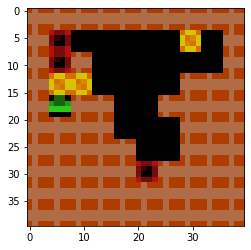

In [130]:
plt.imshow(scaled[0])

In [124]:
"zipped_npy_tiny/"+file_name

'zipped_npy_tiny/next_states_scaled_gameplay_0.npy'

In [156]:
actions = np.array([])
next_states_scaled = np.array([])
scaled = np.array([])

file_name = 'states_gameplay_0.npy'
with open(file_name, 'rb') as f:
    current_array = np.load(f) 

print(file_name)
if file_name.startswith('states_scaled'):
    if len(scaled) == 0:
        scaled = current_array
    else:
        scaled = np.concatenate([scaled, current_array])
elif file_name.startswith('next_states_scaled'):
    if len(next_states_scaled) == 0:
        next_states_scaled = current_array
    else:
        next_states_scaled = np.concatenate([next_states_scaled, current_array])
elif file_name.startswith('actions'):
    if len(actions) == 0:
        actions = current_array
    else:
        actions = np.concatenate([actions, current_array])

states_gameplay_0.npy


In [157]:
current_array.shape

(7, 160, 160, 3)

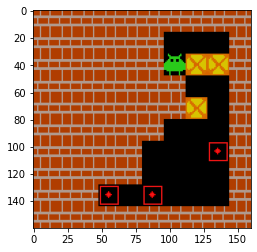

In [162]:
plt.imshow(current_array[3])

In [ ]:
x = encoded(state)
model_mu = torch.nn.Linear( , latent_dim)
model_logvar = torch.nn.Linear( , latent_dim)

mu = model_mu(x)
logvar = model_logvar(x)

z = reparameterize(mu, logvar)

def reparameterize(self, mu, log_var):
    """
    :param mu: mean from the encoder's latent space
    :param log_var: log variance from the encoder's latent space
    """
    std = torch.exp(0.5*log_var) # standard deviation
    eps = torch.randn_like(std) # `randn_like` as we need the same size
    sample = mu + (eps * std) # sampling as if coming from the input space
    return sample


KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())